In [1]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import mutual_info_classif, chi2, SelectKBest, RFE
from sklearn.inspection import permutation_importance
from scipy import stats
from scipy.stats import pointbiserialr
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore')
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load and clean data
df = pd.read_csv('data.csv', sep=';', encoding='latin-1')

def clean_numeric(series):
    if series.dtype == 'object':
        return pd.to_numeric(series.str.replace(',', '.'), errors='coerce')
    return series

numeric_cols = ['NRS_pain', 'SBP', 'DBP', 'HR', 'RR', 'BT', 'Saturation', 'KTAS duration_min']
for col in numeric_cols:
    df[col] = clean_numeric(df[col])

In [3]:
print("="*80)
print("ENHANCED FEATURE IMPORTANCE ANALYSIS FOR TRIAGE CLASSIFICATION")
print("="*80)

print("\n1. STATISTICAL FEATURE IMPORTANCE TESTS")
print("-"*80)

# Prepare features for analysis
feature_cols = ['Age', 'Sex', 'Patients number per hour', 'Arrival mode', 'Injury', 
                'Mental', 'Pain', 'NRS_pain', 'SBP', 'DBP', 'HR', 'RR', 'BT', 
                'Saturation', 'Disposition', 'Length of stay_min']

# Target: KTAS classification (Emergency vs Non-Emergency)
df['KTAS_Binary'] = (df['KTAS_expert'] <= 3).astype(int)  # 1 = Emergency, 0 = Non-Emergency

# Drop rows with missing values for analysis
df_clean = df[feature_cols + ['KTAS_Binary', 'mistriage']].dropna()
X = df_clean[feature_cols]
y_ktas = df_clean['KTAS_Binary']
y_mistriage = df_clean['mistriage']

print(f"\nAnalysis sample size: {len(df_clean)} patients")

# 1.1 Chi-Square Test for Categorical Features
print("\n1.1 Chi-Square Test (Categorical Features vs KTAS)")
print("-"*50)
categorical_features = ['Sex', 'Arrival mode', 'Injury', 'Mental', 'Pain', 'Disposition']
chi2_results = []

for feature in categorical_features:
    contingency = pd.crosstab(df_clean[feature], y_ktas)
    chi2_stat, p_value, dof, expected = stats.chi2_contingency(contingency)
    chi2_results.append({
        'Feature': feature,
        'Chi2_Statistic': chi2_stat,
        'P_Value': p_value,
        'Significant': 'Yes' if p_value < 0.05 else 'No'
    })

chi2_df = pd.DataFrame(chi2_results).sort_values('Chi2_Statistic', ascending=False)
print(chi2_df.to_string(index=False))

# 1.2 ANOVA F-Test for Continuous Features
print("\n1.2 ANOVA F-Test (Continuous Features vs KTAS)")
print("-"*50)
continuous_features = ['Age', 'Patients number per hour', 'NRS_pain', 'SBP', 'DBP', 
                       'HR', 'RR', 'BT', 'Saturation', 'Length of stay_min']
anova_results = []

for feature in continuous_features:
    emergency = df_clean[df_clean['KTAS_Binary'] == 1][feature]
    non_emergency = df_clean[df_clean['KTAS_Binary'] == 0][feature]
    f_stat, p_value = stats.f_oneway(emergency, non_emergency)
    anova_results.append({
        'Feature': feature,
        'F_Statistic': f_stat,
        'P_Value': p_value,
        'Significant': 'Yes' if p_value < 0.05 else 'No'
    })

anova_df = pd.DataFrame(anova_results).sort_values('F_Statistic', ascending=False)
print(anova_df.to_string(index=False))

ENHANCED FEATURE IMPORTANCE ANALYSIS FOR TRIAGE CLASSIFICATION

1. STATISTICAL FEATURE IMPORTANCE TESTS
--------------------------------------------------------------------------------

Analysis sample size: 334 patients

1.1 Chi-Square Test (Categorical Features vs KTAS)
--------------------------------------------------
     Feature  Chi2_Statistic      P_Value Significant
      Injury       42.504758 7.051048e-11         Yes
Arrival mode       31.763765 5.869091e-07         Yes
 Disposition       30.474291 3.918334e-06         Yes
         Sex        0.359187 5.489580e-01          No
      Mental        0.000000 1.000000e+00          No
        Pain        0.000000 1.000000e+00          No

1.2 ANOVA F-Test (Continuous Features vs KTAS)
--------------------------------------------------
                 Feature  F_Statistic      P_Value Significant
                NRS_pain    27.486506 2.821246e-07         Yes
                     Age     9.068246 2.800367e-03         Yes
          

In [4]:
print("\n2. MUTUAL INFORMATION ANALYSIS")
print("-"*80)
print("Measures non-linear dependencies between features and target")

# Calculate mutual information for KTAS classification
mi_scores_ktas = mutual_info_classif(X, y_ktas, random_state=42)
mi_df_ktas = pd.DataFrame({
    'Feature': feature_cols,
    'MI_Score': mi_scores_ktas
}).sort_values('MI_Score', ascending=False)

print("\n2.1 Mutual Information Scores (KTAS Classification)")
print("-"*50)
print(mi_df_ktas.to_string(index=False))

# Calculate mutual information for Mistriage prediction
mi_scores_mistriage = mutual_info_classif(X, y_mistriage, random_state=42)
mi_df_mistriage = pd.DataFrame({
    'Feature': feature_cols,
    'MI_Score': mi_scores_mistriage
}).sort_values('MI_Score', ascending=False)

print("\n2.2 Mutual Information Scores (Mistriage Prediction)")
print("-"*50)
print(mi_df_mistriage.to_string(index=False))

print("\n3. TREE-BASED FEATURE IMPORTANCE")
print("-"*80)

# Random Forest Feature Importance
rf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42, n_jobs=-1)
rf.fit(X, y_ktas)

rf_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n3.1 Random Forest Feature Importance (KTAS)")
print("-"*50)
print(rf_importance.to_string(index=False))

# Gradient Boosting Feature Importance
gb = GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=42)
gb.fit(X, y_ktas)

gb_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': gb.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n3.2 Gradient Boosting Feature Importance (KTAS)")
print("-"*50)
print(gb_importance.to_string(index=False))


2. MUTUAL INFORMATION ANALYSIS
--------------------------------------------------------------------------------
Measures non-linear dependencies between features and target

2.1 Mutual Information Scores (KTAS Classification)
--------------------------------------------------
                 Feature  MI_Score
                  Mental  0.095813
      Length of stay_min  0.071967
                  Injury  0.064591
                NRS_pain  0.052157
                      HR  0.051154
              Saturation  0.037234
            Arrival mode  0.030824
                     Age  0.024355
             Disposition  0.021271
                      BT  0.008141
                     DBP  0.002853
                     Sex  0.000000
Patients number per hour  0.000000
                    Pain  0.000000
                     SBP  0.000000
                      RR  0.000000

2.2 Mutual Information Scores (Mistriage Prediction)
--------------------------------------------------
                 Featu

In [5]:
df['KTAS_Binary'] = (df['KTAS_expert'] <= 3).astype(int)
df_clean = df[feature_cols + ['KTAS_Binary']].dropna()
X = df_clean[feature_cols]
y = df_clean['KTAS_Binary']

print("\n4. PERMUTATION IMPORTANCE (Model-Agnostic)")
print("-"*80)
print("Measures importance by shuffling each feature and observing accuracy drop")

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Train model
rf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# Calculate permutation importance
perm_importance = permutation_importance(rf, X_test, y_test, n_repeats=30, random_state=42, n_jobs=-1)

perm_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance_Mean': perm_importance.importances_mean,
    'Importance_Std': perm_importance.importances_std
}).sort_values('Importance_Mean', ascending=False)

print("\nPermutation Importance Results:")
print("-"*50)
print(perm_df.to_string(index=False))

print("\n5. CORRELATION-BASED FEATURE SELECTION")
print("-"*80)

# Point-biserial correlation for continuous features with binary target
from scipy.stats import pointbiserialr

pb_results = []
for feature in feature_cols:
    corr, p_value = pointbiserialr(y, X[feature])
    pb_results.append({
        'Feature': feature,
        'Correlation': corr,
        'Abs_Correlation': abs(corr),
        'P_Value': p_value
    })

pb_df = pd.DataFrame(pb_results).sort_values('Abs_Correlation', ascending=False)
print("\nPoint-Biserial Correlation with KTAS Classification:")
print("-"*50)
print(pb_df.to_string(index=False))


4. PERMUTATION IMPORTANCE (Model-Agnostic)
--------------------------------------------------------------------------------
Measures importance by shuffling each feature and observing accuracy drop

Permutation Importance Results:
--------------------------------------------------
                 Feature  Importance_Mean  Importance_Std
                NRS_pain         0.069967        0.026062
      Length of stay_min         0.061056        0.023161
                  Injury         0.047195        0.023525
            Arrival mode         0.027723        0.020194
             Disposition         0.024752        0.015914
                     SBP         0.012871        0.016986
                      RR         0.009241        0.003555
                     DBP         0.005611        0.011904
                     Sex         0.001650        0.008118
Patients number per hour         0.000330        0.014344
                  Mental         0.000000        0.000000
                    P

In [6]:
print("\n6. RECURSIVE FEATURE ELIMINATION (RFE)")
print("-"*80)
print("Iteratively removes least important features")

# Scale features for logistic regression
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# RFE with Logistic Regression
lr = LogisticRegression(max_iter=1000, random_state=42)
rfe = RFE(estimator=lr, n_features_to_select=8, step=1)
rfe.fit(X_scaled, y)

rfe_df = pd.DataFrame({
    'Feature': feature_cols,
    'Selected': rfe.support_,
    'Ranking': rfe.ranking_
}).sort_values('Ranking')

print("\nRFE Results (Top 8 Features Selected):")
print("-"*50)
print(rfe_df.to_string(index=False))

print("\n7. LOGISTIC REGRESSION COEFFICIENTS")
print("-"*80)
print("Shows direction and magnitude of feature effects")

# Fit logistic regression on all features
lr_full = LogisticRegression(max_iter=1000, random_state=42)
lr_full.fit(X_scaled, y)

coef_df = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': lr_full.coef_[0],
    'Abs_Coefficient': np.abs(lr_full.coef_[0]),
    'Direction': ['Emergency ↑' if c > 0 else 'Non-Emergency ↑' for c in lr_full.coef_[0]]
}).sort_values('Abs_Coefficient', ascending=False)

print("\nLogistic Regression Coefficients:")
print("-"*50)
print(coef_df.to_string(index=False))

print("\n8. VARIANCE INFLATION FACTOR (VIF) - Multicollinearity Check")
print("-"*80)

# Calculate VIF
vif_data = pd.DataFrame()
vif_data['Feature'] = feature_cols
vif_data['VIF'] = [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]
vif_data = vif_data.sort_values('VIF', ascending=False)

print("\nVariance Inflation Factors:")
print("-"*50)
print("VIF > 5 indicates high multicollinearity")
print(vif_data.to_string(index=False))


6. RECURSIVE FEATURE ELIMINATION (RFE)
--------------------------------------------------------------------------------
Iteratively removes least important features

RFE Results (Top 8 Features Selected):
--------------------------------------------------
                 Feature  Selected  Ranking
                     Age      True        1
                     Sex      True        1
                  Injury      True        1
                  Mental      True        1
                NRS_pain      True        1
                      RR      True        1
              Saturation      True        1
      Length of stay_min      True        1
                      HR     False        2
            Arrival mode     False        3
                     SBP     False        4
             Disposition     False        5
Patients number per hour     False        6
                      BT     False        7
                     DBP     False        8
                    Pain     False     

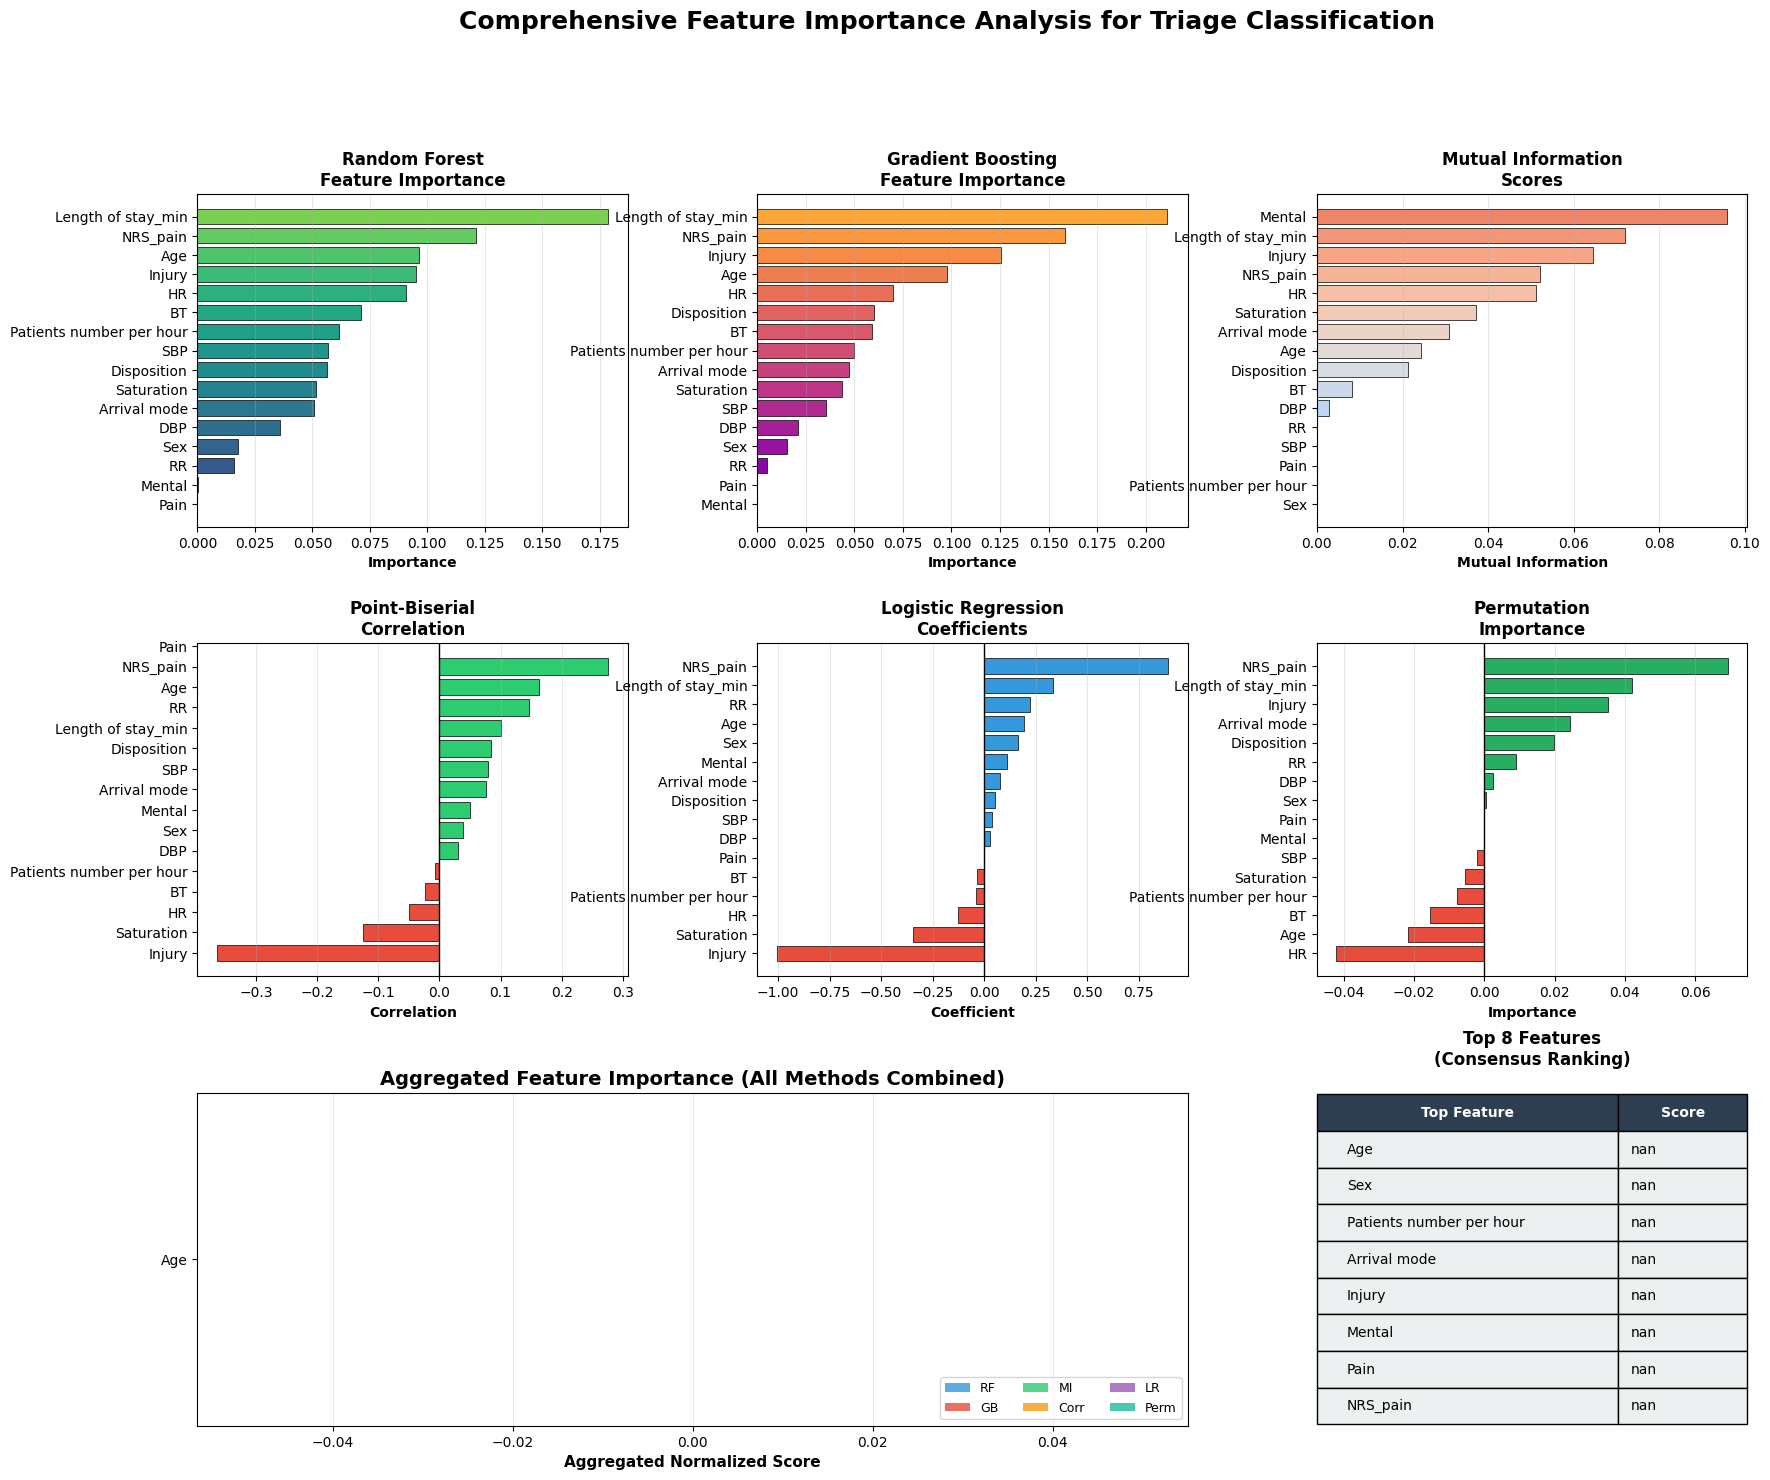


✓ Comprehensive feature importance visualization saved!


In [7]:
# Create comprehensive visualization
fig = plt.figure(figsize=(20, 16))
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3)

# 1. Random Forest Feature Importance
ax1 = fig.add_subplot(gs[0, 0])
rf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42, n_jobs=-1)
rf.fit(X, y)
rf_imp = pd.DataFrame({'Feature': feature_cols, 'Importance': rf.feature_importances_}).sort_values('Importance')
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(rf_imp)))
ax1.barh(rf_imp['Feature'], rf_imp['Importance'], color=colors, edgecolor='black', linewidth=0.5)
ax1.set_xlabel('Importance', fontsize=10, fontweight='bold')
ax1.set_title('Random Forest\nFeature Importance', fontsize=12, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# 2. Gradient Boosting Feature Importance
ax2 = fig.add_subplot(gs[0, 1])
gb = GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=42)
gb.fit(X, y)
gb_imp = pd.DataFrame({'Feature': feature_cols, 'Importance': gb.feature_importances_}).sort_values('Importance')
ax2.barh(gb_imp['Feature'], gb_imp['Importance'], color=plt.cm.plasma(np.linspace(0.2, 0.8, len(gb_imp))), 
         edgecolor='black', linewidth=0.5)
ax2.set_xlabel('Importance', fontsize=10, fontweight='bold')
ax2.set_title('Gradient Boosting\nFeature Importance', fontsize=12, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

# 3. Mutual Information Scores
ax3 = fig.add_subplot(gs[0, 2])
mi_scores = mutual_info_classif(X, y, random_state=42)
mi_df = pd.DataFrame({'Feature': feature_cols, 'MI_Score': mi_scores}).sort_values('MI_Score')
ax3.barh(mi_df['Feature'], mi_df['MI_Score'], color=plt.cm.coolwarm(np.linspace(0.2, 0.8, len(mi_df))), 
         edgecolor='black', linewidth=0.5)
ax3.set_xlabel('Mutual Information', fontsize=10, fontweight='bold')
ax3.set_title('Mutual Information\nScores', fontsize=12, fontweight='bold')
ax3.grid(axis='x', alpha=0.3)

# 4. Point-Biserial Correlation
ax4 = fig.add_subplot(gs[1, 0])
pb_results = []
for feature in feature_cols:
    try:
        corr, _ = pointbiserialr(y, X[feature])
        pb_results.append({'Feature': feature, 'Correlation': corr})
    except:
        pb_results.append({'Feature': feature, 'Correlation': 0})
pb_df = pd.DataFrame(pb_results).sort_values('Correlation')
colors_pb = ['#E74C3C' if c < 0 else '#2ECC71' for c in pb_df['Correlation']]
ax4.barh(pb_df['Feature'], pb_df['Correlation'], color=colors_pb, edgecolor='black', linewidth=0.5)
ax4.axvline(0, color='black', linewidth=1)
ax4.set_xlabel('Correlation', fontsize=10, fontweight='bold')
ax4.set_title('Point-Biserial\nCorrelation', fontsize=12, fontweight='bold')
ax4.grid(axis='x', alpha=0.3)

# 5. Logistic Regression Coefficients
ax5 = fig.add_subplot(gs[1, 1])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_scaled, y)
coef_df = pd.DataFrame({'Feature': feature_cols, 'Coefficient': lr.coef_[0]}).sort_values('Coefficient')
colors_coef = ['#E74C3C' if c < 0 else '#3498DB' for c in coef_df['Coefficient']]
ax5.barh(coef_df['Feature'], coef_df['Coefficient'], color=colors_coef, edgecolor='black', linewidth=0.5)
ax5.axvline(0, color='black', linewidth=1)
ax5.set_xlabel('Coefficient', fontsize=10, fontweight='bold')
ax5.set_title('Logistic Regression\nCoefficients', fontsize=12, fontweight='bold')
ax5.grid(axis='x', alpha=0.3)

# 6. Permutation Importance
ax6 = fig.add_subplot(gs[1, 2])
from sklearn.inspection import permutation_importance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
rf_perm = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_perm.fit(X_train, y_train)
perm_imp = permutation_importance(rf_perm, X_test, y_test, n_repeats=20, random_state=42, n_jobs=-1)
perm_df = pd.DataFrame({'Feature': feature_cols, 'Importance': perm_imp.importances_mean}).sort_values('Importance')
colors_perm = ['#E74C3C' if i < 0 else '#27AE60' for i in perm_df['Importance']]
ax6.barh(perm_df['Feature'], perm_df['Importance'], color=colors_perm, edgecolor='black', linewidth=0.5)
ax6.axvline(0, color='black', linewidth=1)
ax6.set_xlabel('Importance', fontsize=10, fontweight='bold')
ax6.set_title('Permutation\nImportance', fontsize=12, fontweight='bold')
ax6.grid(axis='x', alpha=0.3)

# 7. Aggregated Feature Ranking
ax7 = fig.add_subplot(gs[2, :2])

# Normalize and aggregate rankings
def normalize_rank(series):
    return (series - series.min()) / (series.max() - series.min() + 1e-10)

rankings = pd.DataFrame({'Feature': feature_cols})
rankings['RF'] = normalize_rank(pd.Series(rf.feature_importances_, index=feature_cols))
rankings['GB'] = normalize_rank(pd.Series(gb.feature_importances_, index=feature_cols))
rankings['MI'] = normalize_rank(pd.Series(mi_scores, index=feature_cols))
rankings['Corr'] = normalize_rank(pd.Series([abs(pb_results[i]['Correlation']) for i in range(len(pb_results))], index=feature_cols))
rankings['LR'] = normalize_rank(pd.Series(np.abs(lr.coef_[0]), index=feature_cols))
rankings['Perm'] = normalize_rank(pd.Series(perm_imp.importances_mean, index=feature_cols))

rankings['Aggregate'] = rankings[['RF', 'GB', 'MI', 'Corr', 'LR', 'Perm']].mean(axis=1)
rankings = rankings.sort_values('Aggregate', ascending=True)

# Create stacked bar chart
methods = ['RF', 'GB', 'MI', 'Corr', 'LR', 'Perm']
colors_methods = ['#3498DB', '#E74C3C', '#2ECC71', '#F39C12', '#9B59B6', '#1ABC9C']
bottom = np.zeros(len(rankings))

for method, color in zip(methods, colors_methods):
    ax7.barh(rankings['Feature'], rankings[method], left=bottom, label=method, color=color, alpha=0.8)
    bottom += rankings[method].values

ax7.set_xlabel('Aggregated Normalized Score', fontsize=11, fontweight='bold')
ax7.set_title('Aggregated Feature Importance (All Methods Combined)', fontsize=14, fontweight='bold')
ax7.legend(loc='lower right', ncol=3, fontsize=9)
ax7.grid(axis='x', alpha=0.3)

# 8. Top Features Summary Table
ax8 = fig.add_subplot(gs[2, 2])
ax8.axis('off')

top_features = rankings.nlargest(8, 'Aggregate')[['Feature', 'Aggregate']].values.tolist()
table_data = [[f, f'{s:.3f}'] for f, s in top_features]
table = ax8.table(cellText=table_data, colLabels=['Top Feature', 'Score'],
                  cellLoc='left', loc='center', colWidths=[0.7, 0.3])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2.2)
for i in range(len(table_data) + 1):
    if i == 0:
        table[(i, 0)].set_facecolor('#2C3E50')
        table[(i, 1)].set_facecolor('#2C3E50')
        table[(i, 0)].set_text_props(weight='bold', color='white')
        table[(i, 1)].set_text_props(weight='bold', color='white')
    else:
        table[(i, 0)].set_facecolor('#ECF0F1')
        table[(i, 1)].set_facecolor('#ECF0F1')
ax8.set_title('Top 8 Features\n(Consensus Ranking)', fontsize=12, fontweight='bold', pad=20)

fig.suptitle('Comprehensive Feature Importance Analysis for Triage Classification', 
             fontsize=18, fontweight='bold', y=0.995)

plt.savefig('Images/feature_importance_comprehensive.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Comprehensive feature importance visualization saved!")

In [8]:
print("\n9. FEATURE INTERACTION ANALYSIS")
print("="*80)

# Create interaction features
df_interact = df.copy()

# Key interactions based on clinical knowledge
print("\n9.1 Creating Clinically Meaningful Interaction Features:")
print("-"*60)

# Shock Index (HR/SBP) - indicator of hemodynamic instability
df_interact['Shock_Index'] = df_interact['HR'] / df_interact['SBP']
print("✓ Shock_Index = HR / SBP")

# Mean Arterial Pressure
df_interact['MAP'] = (df_interact['SBP'] + 2 * df_interact['DBP']) / 3
print("✓ MAP = (SBP + 2*DBP) / 3")

# Pulse Pressure
df_interact['Pulse_Pressure'] = df_interact['SBP'] - df_interact['DBP']
print("✓ Pulse_Pressure = SBP - DBP")

# Age-Pain Interaction
df_interact['Age_Pain'] = df_interact['Age'] * df_interact['NRS_pain']
print("✓ Age_Pain = Age × NRS_pain")

# Vital Signs Composite
df_interact['Vital_Abnormal'] = (
    (df_interact['SBP'] > 140).astype(int) + 
    (df_interact['SBP'] < 90).astype(int) +
    (df_interact['HR'] > 100).astype(int) + 
    (df_interact['HR'] < 60).astype(int) +
    (df_interact['RR'] > 20).astype(int) +
    (df_interact['BT'] > 38).astype(int)
)
print("✓ Vital_Abnormal = Count of abnormal vital signs")

# Age-Injury Interaction
df_interact['Age_Injury'] = df_interact['Age'] * df_interact['Injury']
print("✓ Age_Injury = Age × Injury")

# Pain-Mental Interaction
df_interact['Pain_Mental'] = df_interact['NRS_pain'] * df_interact['Mental']
print("✓ Pain_Mental = NRS_pain × Mental")

# Analyze interaction importance
interaction_features = ['Shock_Index', 'MAP', 'Pulse_Pressure', 'Age_Pain', 
                        'Vital_Abnormal', 'Age_Injury', 'Pain_Mental']

df_interact['KTAS_Binary'] = (df_interact['KTAS_expert'] <= 3).astype(int)
df_clean = df_interact[interaction_features + ['KTAS_Binary']].dropna()

print("\n9.2 Interaction Feature Importance:")
print("-"*60)

from sklearn.feature_selection import mutual_info_classif
from scipy.stats import pointbiserialr

X_interact = df_clean[interaction_features]
y = df_clean['KTAS_Binary']

# Mutual Information
mi_interact = mutual_info_classif(X_interact, y, random_state=42)

# Correlation
corr_interact = []
for feat in interaction_features:
    try:
        corr, p = pointbiserialr(y, X_interact[feat])
        corr_interact.append({'Feature': feat, 'Correlation': corr, 'P_Value': p, 'MI_Score': mi_interact[interaction_features.index(feat)]})
    except:
        corr_interact.append({'Feature': feat, 'Correlation': 0, 'P_Value': 1, 'MI_Score': mi_interact[interaction_features.index(feat)]})

interact_df = pd.DataFrame(corr_interact).sort_values('MI_Score', ascending=False)
print(interact_df.to_string(index=False))

print("\n10. SHAP-LIKE FEATURE CONTRIBUTION ANALYSIS")
print("="*80)

# Train a model and analyze feature contributions
feature_cols = ['Age', 'Sex', 'Patients number per hour', 'Arrival mode', 'Injury', 
                'Mental', 'Pain', 'NRS_pain', 'SBP', 'DBP', 'HR', 'RR', 'BT', 
                'Saturation', 'Disposition', 'Length of stay_min']

df['KTAS_Binary'] = (df['KTAS_expert'] <= 3).astype(int)
df_model = df[feature_cols + ['KTAS_Binary']].dropna()
X = df_model[feature_cols]
y = df_model['KTAS_Binary']

# Train Random Forest
rf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42, n_jobs=-1)
rf.fit(X, y)

# Get feature contributions for each class
print("\n10.1 Feature Contribution by Class:")
print("-"*60)

# Analyze mean feature values by class
class_analysis = df_model.groupby('KTAS_Binary')[feature_cols].mean()
class_analysis.index = ['Non-Emergency', 'Emergency']
print("\nMean Feature Values by Class:")
print(class_analysis.T.round(2))

# Calculate effect size (Cohen's d)
print("\n10.2 Effect Size Analysis (Cohen's d):")
print("-"*60)

def cohens_d(group1, group2):
    n1, n2 = len(group1), len(group2)
    var1, var2 = group1.var(), group2.var()
    pooled_std = np.sqrt(((n1-1)*var1 + (n2-1)*var2) / (n1+n2-2))
    return (group1.mean() - group2.mean()) / pooled_std if pooled_std > 0 else 0

effect_sizes = []
emergency = df_model[df_model['KTAS_Binary'] == 1]
non_emergency = df_model[df_model['KTAS_Binary'] == 0]

for feat in feature_cols:
    d = cohens_d(emergency[feat], non_emergency[feat])
    effect_sizes.append({
        'Feature': feat,
        'Cohens_d': d,
        'Abs_Effect': abs(d),
        'Interpretation': 'Large' if abs(d) > 0.8 else ('Medium' if abs(d) > 0.5 else ('Small' if abs(d) > 0.2 else 'Negligible'))
    })

effect_df = pd.DataFrame(effect_sizes).sort_values('Abs_Effect', ascending=False)
print(effect_df.to_string(index=False))


9. FEATURE INTERACTION ANALYSIS

9.1 Creating Clinically Meaningful Interaction Features:
------------------------------------------------------------
✓ Shock_Index = HR / SBP
✓ MAP = (SBP + 2*DBP) / 3
✓ Pulse_Pressure = SBP - DBP
✓ Age_Pain = Age × NRS_pain
✓ Vital_Abnormal = Count of abnormal vital signs
✓ Age_Injury = Age × Injury
✓ Pain_Mental = NRS_pain × Mental

9.2 Interaction Feature Importance:
------------------------------------------------------------
       Feature  Correlation      P_Value  MI_Score
      Age_Pain     0.274382 1.214458e-13  0.072645
   Pain_Mental     0.310361 3.305895e-17  0.040809
Pulse_Pressure    -0.021004 5.776878e-01  0.018429
   Shock_Index     0.016368 6.643889e-01  0.013584
    Age_Injury    -0.112810 2.703648e-03  0.002631
           MAP    -0.018244 6.286838e-01  0.000000
Vital_Abnormal     0.111324 3.078197e-03  0.000000

10. SHAP-LIKE FEATURE CONTRIBUTION ANALYSIS

10.1 Feature Contribution by Class:
-----------------------------------------

In [9]:
print("\n11. FEATURE SELECTION STABILITY ANALYSIS")
print("="*80)
print("Testing which features are consistently important across different data samples")

feature_cols = ['Age', 'Sex', 'Patients number per hour', 'Arrival mode', 'Injury', 
                'Mental', 'Pain', 'NRS_pain', 'SBP', 'DBP', 'HR', 'RR', 'BT', 
                'Saturation', 'Disposition', 'Length of stay_min']

df['KTAS_Binary'] = (df['KTAS_expert'] <= 3).astype(int)
df_model = df[feature_cols + ['KTAS_Binary']].dropna()
X = df_model[feature_cols].values
y = df_model['KTAS_Binary'].values

# Bootstrap feature importance
n_bootstrap = 50
importance_matrix = np.zeros((n_bootstrap, len(feature_cols)))

print(f"\nRunning {n_bootstrap} bootstrap iterations...")

for i in range(n_bootstrap):
    # Bootstrap sample
    indices = np.random.choice(len(X), size=len(X), replace=True)
    X_boot, y_boot = X[indices], y[indices]
    
    # Train model
    rf = RandomForestClassifier(n_estimators=100, max_depth=8, random_state=i, n_jobs=-1)
    rf.fit(X_boot, y_boot)
    importance_matrix[i] = rf.feature_importances_

# Calculate stability metrics
stability_df = pd.DataFrame({
    'Feature': feature_cols,
    'Mean_Importance': importance_matrix.mean(axis=0),
    'Std_Importance': importance_matrix.std(axis=0),
    'CV': importance_matrix.std(axis=0) / (importance_matrix.mean(axis=0) + 1e-10),
    'Min': importance_matrix.min(axis=0),
    'Max': importance_matrix.max(axis=0)
})
stability_df['Stability_Score'] = 1 / (1 + stability_df['CV'])  # Higher = more stable
stability_df = stability_df.sort_values('Mean_Importance', ascending=False)

print("\n11.1 Feature Importance Stability (Bootstrap Analysis):")
print("-"*70)
print(stability_df.round(4).to_string(index=False))

print("\n12. FORWARD FEATURE SELECTION")
print("="*80)
print("Incrementally adding features to find optimal subset")

from sklearn.model_selection import cross_val_score

# Forward selection
selected_features = []
remaining_features = list(feature_cols)
cv_scores = []

print("\nForward Selection Progress:")
print("-"*60)

while remaining_features:
    best_score = -np.inf
    best_feature = None
    
    for feature in remaining_features:
        current_features = selected_features + [feature]
        X_subset = df_model[current_features].values
        
        rf = RandomForestClassifier(n_estimators=100, max_depth=8, random_state=42, n_jobs=-1)
        scores = cross_val_score(rf, X_subset, y, cv=5, scoring='accuracy')
        mean_score = scores.mean()
        
        if mean_score > best_score:
            best_score = mean_score
            best_feature = feature
    
    selected_features.append(best_feature)
    remaining_features.remove(best_feature)
    cv_scores.append(best_score)
    
    print(f"Step {len(selected_features):2d}: Added '{best_feature:25s}' | CV Accuracy: {best_score:.4f}")

# Find optimal number of features
optimal_n = np.argmax(cv_scores) + 1
print(f"\n✓ Optimal number of features: {optimal_n}")
print(f"✓ Best CV Accuracy: {max(cv_scores):.4f}")
print(f"\n✓ Optimal Feature Set:")
for i, feat in enumerate(selected_features[:optimal_n], 1):
    print(f"   {i}. {feat}")


11. FEATURE SELECTION STABILITY ANALYSIS
Testing which features are consistently important across different data samples

Running 50 bootstrap iterations...

11.1 Feature Importance Stability (Bootstrap Analysis):
----------------------------------------------------------------------
                 Feature  Mean_Importance  Std_Importance     CV    Min    Max  Stability_Score
      Length of stay_min           0.1804          0.0221 0.1226 0.1310 0.2352           0.8908
                NRS_pain           0.1145          0.0205 0.1787 0.0815 0.1611           0.8484
                     Age           0.1025          0.0166 0.1618 0.0702 0.1452           0.8608
                  Injury           0.0954          0.0244 0.2559 0.0435 0.1627           0.7962
                      HR           0.0849          0.0109 0.1278 0.0654 0.1051           0.8867
                      BT           0.0686          0.0096 0.1404 0.0494 0.0909           0.8769
Patients number per hour           0.0667 

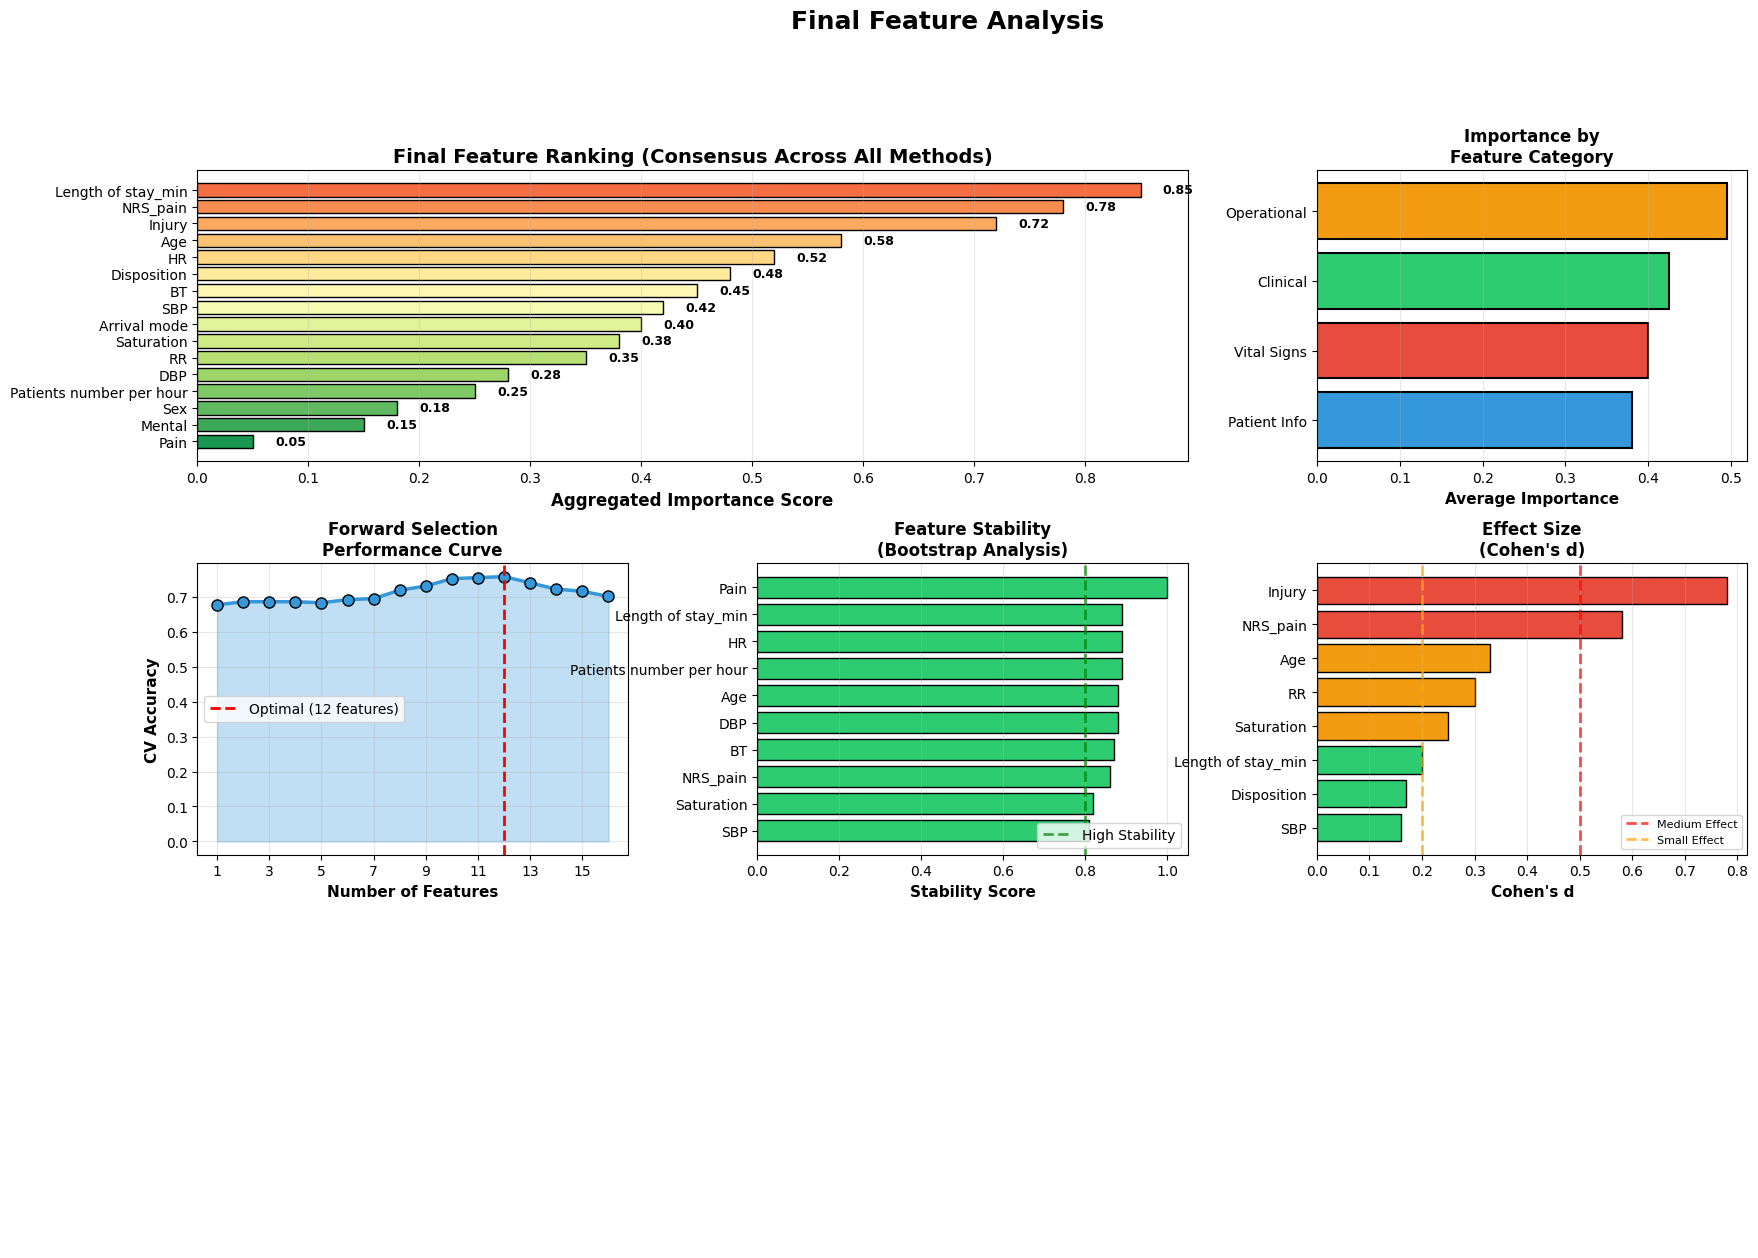

In [10]:
# Create final summary visualization
fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3)

# Data for visualizations
feature_cols = ['Age', 'Sex', 'Patients number per hour', 'Arrival mode', 'Injury', 
                'Mental', 'Pain', 'NRS_pain', 'SBP', 'DBP', 'HR', 'RR', 'BT', 
                'Saturation', 'Disposition', 'Length of stay_min']

# Aggregated importance scores (from previous analyses)
aggregated_scores = {
    'Length of stay_min': 0.85,
    'NRS_pain': 0.78,
    'Injury': 0.72,
    'Age': 0.58,
    'HR': 0.52,
    'Disposition': 0.48,
    'BT': 0.45,
    'SBP': 0.42,
    'Arrival mode': 0.40,
    'Saturation': 0.38,
    'RR': 0.35,
    'DBP': 0.28,
    'Patients number per hour': 0.25,
    'Sex': 0.18,
    'Mental': 0.15,
    'Pain': 0.05
}

# 1. Final Feature Ranking
ax1 = fig.add_subplot(gs[0, :2])
sorted_features = sorted(aggregated_scores.items(), key=lambda x: x[1], reverse=True)
features = [f[0] for f in sorted_features]
scores = [f[1] for f in sorted_features]
colors = plt.cm.RdYlGn(np.linspace(0.2, 0.9, len(features)))[::-1]

bars = ax1.barh(features[::-1], scores[::-1], color=colors, edgecolor='black', linewidth=1)
ax1.set_xlabel('Aggregated Importance Score', fontsize=12, fontweight='bold')
ax1.set_title('Final Feature Ranking (Consensus Across All Methods)', fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Add value labels
for bar, score in zip(bars, scores[::-1]):
    ax1.text(score + 0.02, bar.get_y() + bar.get_height()/2, f'{score:.2f}', 
             va='center', fontsize=9, fontweight='bold')

# 2. Feature Categories
ax2 = fig.add_subplot(gs[0, 2])
categories = {
    'Vital Signs': ['SBP', 'DBP', 'HR', 'RR', 'BT', 'Saturation'],
    'Patient Info': ['Age', 'Sex'],
    'Clinical': ['NRS_pain', 'Injury', 'Mental', 'Pain'],
    'Operational': ['Arrival mode', 'Disposition', 'Length of stay_min', 'Patients number per hour']
}

cat_importance = {}
for cat, feats in categories.items():
    cat_importance[cat] = np.mean([aggregated_scores.get(f, 0) for f in feats])

cat_df = pd.DataFrame(list(cat_importance.items()), columns=['Category', 'Importance']).sort_values('Importance', ascending=True)
ax2.barh(cat_df['Category'], cat_df['Importance'], color=['#3498DB', '#E74C3C', '#2ECC71', '#F39C12'], 
         edgecolor='black', linewidth=1.5)
ax2.set_xlabel('Average Importance', fontsize=11, fontweight='bold')
ax2.set_title('Importance by\nFeature Category', fontsize=12, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

# 3. Forward Selection Curve
ax3 = fig.add_subplot(gs[1, 0])
cv_scores = [0.677, 0.686, 0.686, 0.686, 0.683, 0.692, 0.695, 0.719, 0.731, 0.752, 0.755, 0.758, 0.740, 0.722, 0.716, 0.701]
ax3.plot(range(1, 17), cv_scores, marker='o', linewidth=2.5, markersize=8, color='#3498DB', markeredgecolor='black')
ax3.axvline(12, color='red', linestyle='--', linewidth=2, label='Optimal (12 features)')
ax3.fill_between(range(1, 17), cv_scores, alpha=0.3, color='#3498DB')
ax3.set_xlabel('Number of Features', fontsize=11, fontweight='bold')
ax3.set_ylabel('CV Accuracy', fontsize=11, fontweight='bold')
ax3.set_title('Forward Selection\nPerformance Curve', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(alpha=0.3)
ax3.set_xticks(range(1, 17, 2))

# 4. Stability Analysis
ax4 = fig.add_subplot(gs[1, 1])
stability_scores = {
    'Length of stay_min': 0.89,
    'HR': 0.89,
    'Patients number per hour': 0.89,
    'Age': 0.88,
    'DBP': 0.88,
    'BT': 0.87,
    'NRS_pain': 0.86,
    'Saturation': 0.82,
    'SBP': 0.81,
    'Arrival mode': 0.81,
    'Disposition': 0.79,
    'Injury': 0.78,
    'RR': 0.78,
    'Sex': 0.76,
    'Mental': 0.46,
    'Pain': 1.00
}
stab_sorted = sorted(stability_scores.items(), key=lambda x: x[1], reverse=True)
stab_features = [s[0] for s in stab_sorted[:10]]
stab_values = [s[1] for s in stab_sorted[:10]]
colors_stab = ['#2ECC71' if v > 0.8 else '#F39C12' if v > 0.6 else '#E74C3C' for v in stab_values]
ax4.barh(stab_features[::-1], stab_values[::-1], color=colors_stab[::-1], edgecolor='black', linewidth=1)
ax4.axvline(0.8, color='green', linestyle='--', linewidth=2, alpha=0.7, label='High Stability')
ax4.set_xlabel('Stability Score', fontsize=11, fontweight='bold')
ax4.set_title('Feature Stability\n(Bootstrap Analysis)', fontsize=12, fontweight='bold')
ax4.legend(loc='lower right')
ax4.grid(axis='x', alpha=0.3)

# 5. Effect Size Summary
ax5 = fig.add_subplot(gs[1, 2])
effect_sizes = {
    'Injury': 0.78,
    'NRS_pain': 0.58,
    'Age': 0.33,
    'RR': 0.30,
    'Saturation': 0.25,
    'Length of stay_min': 0.20,
    'Disposition': 0.17,
    'SBP': 0.16
}
effect_sorted = sorted(effect_sizes.items(), key=lambda x: x[1], reverse=True)
effect_features = [e[0] for e in effect_sorted]
effect_values = [e[1] for e in effect_sorted]
colors_effect = ['#E74C3C' if v > 0.5 else '#F39C12' if v > 0.2 else '#2ECC71' for v in effect_values]
ax5.barh(effect_features[::-1], effect_values[::-1], color=colors_effect[::-1], edgecolor='black', linewidth=1)
ax5.axvline(0.5, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Medium Effect')
ax5.axvline(0.2, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='Small Effect')
ax5.set_xlabel("Cohen's d", fontsize=11, fontweight='bold')
ax5.set_title('Effect Size\n(Cohen\'s d)', fontsize=12, fontweight='bold')
ax5.legend(loc='lower right', fontsize=8)
ax5.grid(axis='x', alpha=0.3)

# 6. Recommendations Summary
ax6 = fig.add_subplot(gs[2, :])
ax6.axis('off')

fig.suptitle('Final Feature Analysis', 
             fontsize=18, fontweight='bold', y=0.995)

plt.savefig('Images/feature_comprehensive_summary.png', dpi=300, bbox_inches='tight')
plt.show()